In [1]:
#Plot the measured spectra

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
exec(open("nb_setup.py").read())
from constants import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


In [4]:
import R68_load as r68
meas=r68.load_measured()

Loading Measured Data...
(480634,)
(174510,)


In [5]:
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)
Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

In [6]:
#Measured
N_meas_PuBe,_ = np.histogram(meas['PuBe']['E'],bins=Ebins)
N_meas_Bkg,_ = np.histogram(meas['Bkg']['E'],bins=Ebins)

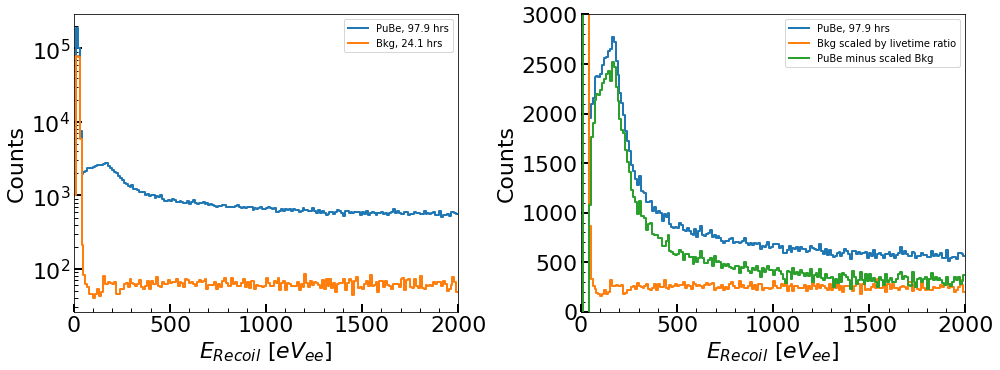

In [33]:
fig_w=7
fig,ax = plt.subplots(1,2,figsize=(2*fig_w, fig_w*(.75)))

ax[0].step(Ebin_ctr,N_meas_PuBe,where='mid', linewidth=2, label='PuBe, {} hrs'.format(meas['PuBe']['tlive']/3600))
ax[0].step(Ebin_ctr,N_meas_Bkg,where='mid', linewidth=2, label='Bkg, {} hrs'.format(meas['Bkg']['tlive']/3600))

ax[0].set_xlim(0,2e3)
ax[0].set_yscale('log')
ax[0].set_ylabel('Counts')
ax[0].set_xlabel(r'$E_{Recoil}~[eV_{ee}]$')

ax[0].legend()

ax[1].step(Ebin_ctr,N_meas_PuBe,where='mid', linewidth=2, label='PuBe, {} hrs'.format(meas['PuBe']['tlive']/3600))
ax[1].step(Ebin_ctr,N_meas_Bkg*meas['PuBe']['tlive']/meas['Bkg']['tlive'],where='mid', linewidth=2, label='Bkg scaled by livetime ratio')
ax[1].step(Ebin_ctr,N_meas_PuBe-N_meas_Bkg*meas['PuBe']['tlive']/meas['Bkg']['tlive'],where='mid', linewidth=2, label='PuBe minus scaled Bkg')

ax[1].set_xlim(0,2e3)
ax[1].set_ylim(0,3e3)
ax[1].set_ylabel('Counts')
ax[1].set_xlabel(r'$E_{Recoil}~[eV_{ee}]$')

ax[1].legend()

plt.tight_layout()
plt.savefig('figures/meas_spec_subtraction.png')